In [1]:
%load_ext lab_black
%config IPCompleter.greedy=True

# M14 - Digitale Signalverarbeitung
## Aufgabe 3 - Signalkodierung

# 0 Einrichten der Umgebung
## 0.1 Laden der Bibelioteken

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import IPython
from typing import List, Set, Dict, Tuple, Any

In [3]:
IPython.display.set_matplotlib_formats("pdf", "svg")

# 1 Bitgenerierung

## 1.1 Bit Folge

In [4]:
def generate_bits(preamble: np.array = np.array([], dtype=int), n_bits: int = 24):
    if type(n_bits) != int:
        raise TypeError(f"Expected n_bits to be of type int, got {type(n_bits)}.")
    if n_bits < len(preamble):
        raise ValueError(
            f"Expectet n_bit to be greater than preamble: {len(preamble)}."
        )

    random_bits: np.ndarray = np.random.randint(0, 2, size=n_bits - len(preamble))
    bits: list = np.concatenate((preamble, random_bits), axis=0)
    return bits

# 2.0 Pegel-Kodierung
## 2.1 NRZ

In [5]:
def generate_levels(bits: np.array, pegel: np.array = np.array([0, 3.3])) -> np.ndarray:
    if len(pegel) != 2:
        raise ValueError(f"Expectet size of n_bit to be 2, got {len(pegel)}.")

    levels: np.ndarray = np.array([pegel[0] if bit == 0 else pegel[1] for bit in bits])
    return levels

## 2.2 Manchester Codierung PSK (IEEE 802.3 10-Mbit/s-Ethernet)

In [6]:
def generate_manchester(bits: np.array) -> np.array:
    bit_list: list
    bit_list = [(1.8, -1.8) if bit == 0 else (-1.8, 1.8) for bit in bits]
    levels: np.array = np.array(bit_list)
    levels = levels.reshape(1, -1).squeeze()
    return levels

## 3. Rauschen

In [7]:
def generate_noise(
    n_bits: int = 24, pegel: Tuple[float, float] = (-0.7, 0.7)
) -> np.array:
    n_numbers: int = n_bits * 5
    noise_width: int = abs(pegel[0]) + abs(pegel[1])
    noise: np.array
    noise = np.random.random_sample(size=n_numbers) * noise_width + pegel[0]
    return noise

In [8]:
generate_noise(2, (-5, 5))

array([ 3.98507746,  3.44192742,  2.0122973 , -3.51301224, -2.00354772,
        0.52841628,  2.79037494, -3.38223234, -2.89439547, -4.78265332])

# 8. Ausführung

In [38]:
SAMPLE_TIME = 5  # per second
PREAMBLE: np.ndarray = np.array([1, 0, 1, 0, 1, 0, 1, 0])

time = np.arange(0, 24.0, 1 / SAMPLE_TIME)

noise = generate_noise(24, (-0.7, 0.7))

bits = generate_bits(PREAMBLE, 24)
bit_levels = generate_levels(bits, (0, 3.3))
bit_levels = bit_levels.repeat(5, axis=0)  # supersample 5 times

nrz = generate_levels(bits, (-1.0, 1.0))
nrz = nrz.repeat(5, axis=0)  # supersample 5 times
nrz_noise = nrz + noise
nrz_error_count = np.sum(nrz_noise > 0.6) + np.sum(nrz_noise < -0.6)


# PSK double Frequency
time_manchester = np.arange(0, 24.0, 1 / (2 * SAMPLE_TIME))
manchester = generate_manchester(bits)
manchester = manchester.repeat(5, axis=0)  # supersample 5 times
manchester_noise = manchester + noise.repeat(2, axis=0)
manchester_error_count = np.sum(manchester_noise > 1.3) + np.sum(
    manchester_noise < -1.3
)

# 9. Darstellung

In [10]:
STEMLINE_WIDTH = 0.75
MARKERSIZE = 2
XRANGE = (-0.5, 25.5)

## 9.1 Bitsignal

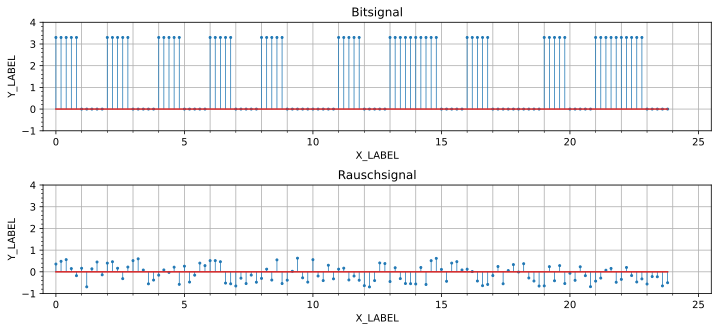

In [11]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=[12, 5])
ax0 = fig.add_subplot(axs[0])
ax1 = fig.add_subplot(axs[1])

# Axis 1 - Bitsignal
ax0.set_xlim(*XRANGE)
ax0.set_ylim(-1.0, 4.0)

ax0.set_title("Bitsignal")
ax0.set_xlabel("X_LABEL")
ax0.set_ylabel("Y_LABEL")

ax0.grid(True, which="major")
ax0.grid(True, which="minor", axis="x")
ax0.minorticks_on()

markerline, stemline, baseline = ax0.stem(time, bit_levels)
plt.setp(stemline, linewidth=STEMLINE_WIDTH)
plt.setp(markerline, markersize=MARKERSIZE)

# Axis 2 - Rauschsignal
ax1.set_xlim(*XRANGE)
ax1.set_ylim(-1.0, 4.0)

ax1.set_title("Rauschsignal")
ax1.set_xlabel("X_LABEL")
ax1.set_ylabel("Y_LABEL")

ax1.grid(True, which="major")
ax1.grid(True, which="minor", axis="x")
ax1.minorticks_on()

markerline, stemline, baseline = ax1.stem(time, noise)
plt.setp(stemline, linewidth=STEMLINE_WIDTH)
plt.setp(markerline, markersize=MARKERSIZE)

left = None  # 0.125  # the left side of the subplots of the figure
right = None  # 0.9    # the right side of the subplots of the figure
bottom = None  # 0.1   # the bottom of the subplots of the figure
top = None  # 0.9      # the top of the subplots of the figure
wspace = None  # the amount of width reserved for blank space between subplots
hspace = 0.5  # 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(
    left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace
)

del fig, axs, ax0, ax1

## 9.2 NRZ Kodiert

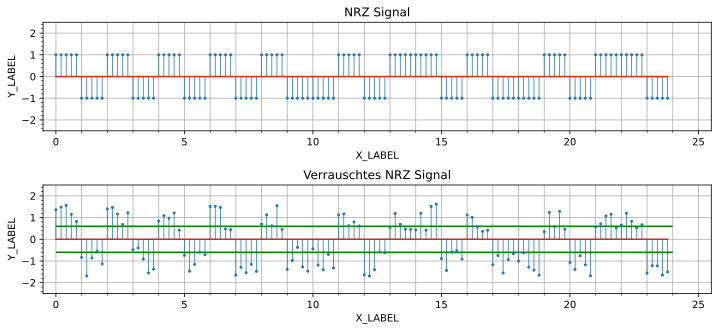

In [25]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=[12, 5])
ax0 = fig.add_subplot(axs[0])
ax1 = fig.add_subplot(axs[1])

# Axis 1 - Bitsignal
ax0.set_xlim(*XRANGE)
ax0.set_ylim(-2.5, 2.5)

ax0.set_title("NRZ Signal")
ax0.set_xlabel("X_LABEL")
ax0.set_ylabel("Y_LABEL")

ax0.grid(True, which="major")
ax0.grid(True, which="minor", axis="x")
ax0.minorticks_on()

markerline, stemline, baseline = ax0.stem(time, nrz)
plt.setp(stemline, linewidth=STEMLINE_WIDTH)
plt.setp(markerline, markersize=MARKERSIZE)

# Axis 2 - Rauschsignal
ax1.set_xlim(*XRANGE)
ax1.set_ylim(-2.5, 2.5)

ax1.set_title("Verrauschtes NRZ Signal")
ax1.set_xlabel("X_LABEL")
ax1.set_ylabel("Y_LABEL")

ax1.grid(True, which="major")
ax1.grid(True, which="minor", axis="x")
ax1.minorticks_on()

markerline, stemline, baseline = ax1.stem(time, nrz_noise)
plt.setp(stemline, linewidth=STEMLINE_WIDTH)
plt.setp(markerline, markersize=MARKERSIZE)
ax1.hlines(0.6, 0.0, 24.00, colors="g", linestyles="solid", label="Error threshold")
ax1.hlines(-0.6, 0.0, 24.00, colors="g", linestyles="solid", label="Error threshold")

left = None  # 0.125  # the left side of the subplots of the figure
right = None  # 0.9    # the right side of the subplots of the figure
bottom = None  # 0.1   # the bottom of the subplots of the figure
top = None  # 0.9      # the top of the subplots of the figure
wspace = None  # the amount of width reserved for blank space between subplots
hspace = 0.5  # 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(
    left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace
)

del fig, axs, ax0, ax1

## 9.2 Manchester PSK (IEEE 802.3 10-Mbit/s-Ethernet)

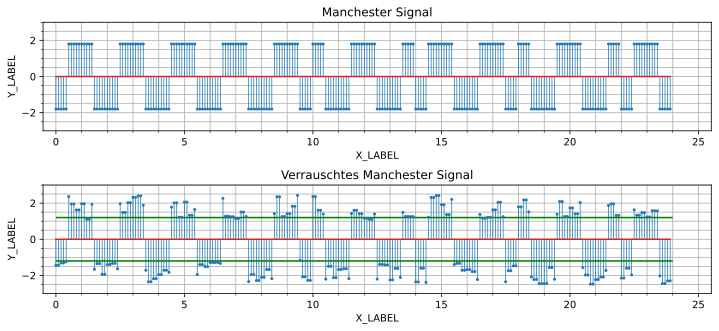

In [24]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=[12, 5])
ax0 = fig.add_subplot(axs[0])
ax1 = fig.add_subplot(axs[1])

# Axis 1 - Bitsignal
ax0.set_xlim(*XRANGE)
ax0.set_ylim(-3.0, 3.0)

ax0.set_title("Manchester Signal")
ax0.set_xlabel("X_LABEL")
ax0.set_ylabel("Y_LABEL")

ax0.grid(True, which="major")
ax0.grid(True, which="minor")
ax0.minorticks_on()

markerline, stemline, baseline = ax0.stem(time_manchester, manchester)
plt.setp(stemline, linewidth=STEMLINE_WIDTH)
plt.setp(markerline, markersize=MARKERSIZE)

# Axis 2 - Rauschsignal
ax1.set_xlim(*XRANGE)
ax1.set_ylim(-3.0, 3.0)

ax1.set_title("Verrauschtes Manchester Signal")
ax1.set_xlabel("X_LABEL")
ax1.set_ylabel("Y_LABEL")

ax1.grid(True, which="major")
ax1.grid(True, which="minor")
ax1.minorticks_on()

markerline, stemline, baseline = ax1.stem(time_manchester, manchester_noise)
plt.setp(stemline, linewidth=STEMLINE_WIDTH)
plt.setp(markerline, markersize=MARKERSIZE)
ax1.hlines(1.2, 0.0, 24.00, colors="g", linestyles="solid", label="Error threshold")
ax1.hlines(-1.2, 0.0, 24.00, colors="g", linestyles="solid", label="Error threshold")

left = None  # 0.125  # the left side of the subplots of the figure
right = None  # 0.9    # the right side of the subplots of the figure
bottom = None  # 0.1   # the bottom of the subplots of the figure
top = None  # 0.9      # the top of the subplots of the figure
wspace = None  # the amount of width reserved for blank space between subplots
hspace = 0.5  # 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(
    left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace
)

del fig, axs, ax0, ax1